In [39]:
import struct
import time
from pathlib import Path

from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [40]:
def load_label(filename):
    with open(filename, "rb") as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        return np.fromfile(flbl, dtype=np.int8)


def load_data(filename):
    with open(filename, "rb") as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        return np.fromfile(fimg, dtype=np.uint8).reshape(num, rows, cols)


BASE = Path("./mnist")

train_images = torch.tensor(load_data(BASE / "train-images-idx3-ubyte")).long()
train_labels = torch.tensor(load_label(BASE / "train-labels-idx1-ubyte")).long()
test_images = torch.tensor(load_data(BASE / "t10k-images-idx3-ubyte")).long()
test_labels = torch.tensor(load_label(BASE / "t10k-labels-idx1-ubyte")).long()

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [41]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=10):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 16, bias=False)
        self.layer2 = nn.Linear(16, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        return self.layer2(x)


In [42]:
def normalize_input(images, size, depth):
    resize = transforms.Resize(size)
    images = resize(images).long()
    images = torch.flatten(images, start_dim=1)
    return images >> (8 - depth)


In [44]:
BATCH_SIZE = 200
INPUT_SIZE = 8
INPUT_DEPTH = 4
INPUT_COUNT = train_labels.shape[0]

net = MLP(INPUT_SIZE**2)


train_inputs = normalize_input(train_images, INPUT_SIZE, INPUT_DEPTH)
test_inputs = normalize_input(test_images, INPUT_SIZE, INPUT_DEPTH)
train_output = F.one_hot(train_labels, num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


start = time.time()
for epoch in range(32):
    running_loss = 0
    running_error = 0
    num_batches = 0
    shuffled_indices = torch.randperm(INPUT_COUNT)
    for count in range(0, INPUT_COUNT, BATCH_SIZE):
        indices = shuffled_indices[count : count + BATCH_SIZE]

        batch_inputs = train_inputs[indices]
        batch_output = train_output[indices]

        # forward and backward pass
        optimizer.zero_grad()
        loss = criterion(net(batch_inputs.float()), batch_output.float())
        loss.backward()
        optimizer.step()

        # compute some stats
        running_loss += loss.detach().item()
        num_batches += 1

        total_loss = running_loss / num_batches
        # total_error = running_error / num_batches
        elapsed_time = time.time() - start

        if num_batches % 100 == 0:
            with torch.no_grad():
                outputs = net(test_inputs.float())
                correct = sum(outputs.argmax(dim=1) == test_labels).item()

            print(
                {
                    "epoch": epoch,
                    "batches": num_batches,
                    "elapsed_time": round(elapsed_time, 2),
                    "total_loss": total_loss,
                    "accuracy": round(correct / len(test_inputs) * 100, 2),
                }
            )


{'epoch': 0, 'batches': 100, 'elapsed_time': 1.06, 'total_loss': 1.884160852432251, 'accuracy': 61.41}
{'epoch': 0, 'batches': 200, 'elapsed_time': 2.22, 'total_loss': 1.4602892306447028, 'accuracy': 75.36}
{'epoch': 0, 'batches': 300, 'elapsed_time': 3.57, 'total_loss': 1.2368042226632436, 'accuracy': 78.57}
{'epoch': 1, 'batches': 100, 'elapsed_time': 4.8, 'total_loss': 0.703439564704895, 'accuracy': 80.5}
{'epoch': 1, 'batches': 200, 'elapsed_time': 6.22, 'total_loss': 0.6813731861114501, 'accuracy': 81.54}
{'epoch': 1, 'batches': 300, 'elapsed_time': 7.34, 'total_loss': 0.6646083465218544, 'accuracy': 81.94}
{'epoch': 2, 'batches': 100, 'elapsed_time': 8.46, 'total_loss': 0.6162484166026115, 'accuracy': 82.74}
{'epoch': 2, 'batches': 200, 'elapsed_time': 9.42, 'total_loss': 0.6057436583936214, 'accuracy': 83.05}
{'epoch': 2, 'batches': 300, 'elapsed_time': 10.79, 'total_loss': 0.5942278824249904, 'accuracy': 83.5}
{'epoch': 3, 'batches': 100, 'elapsed_time': 11.79, 'total_loss': 0.

In [45]:
def predict(inputs, w1, w2, b):
    x = inputs @ w1
    x = x * (x > 0)
    x = x @ w2 + b
    return np.argmax(x, axis=1)
    
def clip(arr, scale, bits):
    imax = 2 ** (bits - 1) - 1
    imin = -(2 ** (bits - 1))
    
    return np.clip(arr * scale, imin, imax)


In [46]:
data = []

weight1 = net.layer1.weight.detach().numpy().transpose()
weight2 = net.layer2.weight.detach().numpy().transpose()
bias = net.layer2.bias.detach().numpy()

for i in range(0, 32):
    SCALE = 1 << i

    w1 = clip(weight1, SCALE, 8).astype(np.int8)
    w2 = clip(weight2, SCALE, 8).astype(np.int8)
    b = clip(bias, SCALE, 8).astype(np.int8)

    pred = predict(test_inputs.numpy(), w1, w2, b)
    data.append({
        'pow': i,
        'scale': SCALE,
        'accuracy': sum(pred == test_labels.numpy()) / len(test_labels)
    })

stat = pd.DataFrame(data)

,pow,scale,accuracy
0,0,1,0.0980
1,1,2,0.0980
2,2,4,0.2776
3,3,8,0.7044
4,4,16,0.8365
5,5,32,0.8686
6,6,64,0.8819
7,7,128,0.8827
8,8,256,0.8611
9,9,512,0.6614


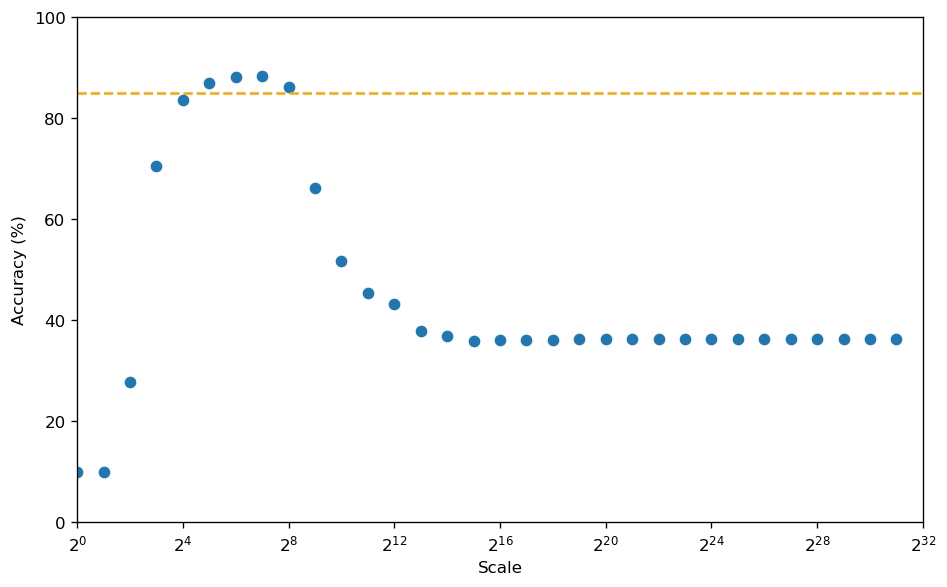

In [47]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.scatter(stat['scale'], stat['accuracy']*100)
ax.axhline(y=85, color='orange', linestyle='dashed')
ax.set_xscale('log', base=2)
ax.set_xlabel('Scale')
ax.set_xlim(1, 2**32)
ax.set_ylabel('Accuracy (%)')
ax.set_ylim(0, 100)
fig.tight_layout()
fig.savefig("customized.pdf")
fig.savefig("customized.png")

In [48]:
scale = stat.set_index('scale')['accuracy'].idxmax()
w1 = clip(weight1, scale, 8).astype(np.int8)
w2 = clip(weight2, scale, 8).astype(np.int8)
b = clip(bias, scale, 8).astype(np.int8)

np.save('test_data_custom', test_inputs)
np.save('test_label_custom', test_labels)
np.save('model_weight1_custom', w1)
np.save('model_weight2_custom', w2)
np.save('model_bias_custom', b)

In [49]:
scale

128